In [52]:
import ROOT

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, accuracy_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

%matplotlib inline

In [54]:
root_dir = '/home/artem145/NEWS/root_files/Valerio/'

In [55]:
def get_pol_feat(id_frame, n_pol, root_dir, class_name, feat_names):
    
    f = ROOT.TFile.Open(root_dir+class_name+'/dm_tracks.dm.root','read')
    t = f.Get('Vdmr')
    all_feat = pd.DataFrame(columns=feat_names).values
    
    for pol_id in id_frame[['ViewID','pol'+str(n_pol)]].values:
        pol_feat = []
        t.GetEntry(int(pol_id[0]))
        for name in feat_names:
            pol_feat.append(t.GetLeaf('cl.'+name).GetValue(int(pol_id[1])))
        all_feat = np.vstack((all_feat, pol_feat))
    return pd.DataFrame(all_feat, columns=feat_names)

In [56]:
def stack_pols(pol_frames, feat_names):
    
    stacked = pol_frames[0].drop(feat_names, axis=1).values
    feat_array = []
    for i in range(len(pol_frames)):
        stacked = np.hstack((stacked,pol_frames[i]))
        for name in feat_names:
            feat_array.append(name+str(i))
    return pd.DataFrame(stacked, columns=feat_array)

In [57]:
def feat_to_input(ft_data, cl_names):
    """
    Stacking data with names from 'cl_names' into one feature array
    and labeling 'signal' with 1 and 'noise' with 0.
    -------
    Output:
    X - array of features
    y - array of corresponding target labels
    """
    X = pd.DataFrame(columns=ft_data[cl_names[0]].columns).values
    y = []
    for name in cl_names:
        idx = ft_data[name].index
        if name[0] == 'C' :
            targ = np.ones(len(idx))
        else: targ = np.zeros(len(idx))
        y = np.append(y,targ)
        X = np.vstack((X, ft_data[name].values))
    return X, y

In [58]:
feat_names = ['x','y','z','lx','ly','phi','npx','vol']

In [59]:
class_names = ['C100keV', 'TestSample']

In [60]:
n_pols = 8

In [61]:
pol_ids = {}
for name in class_names:
    pol_ids[name] = pd.read_csv(root_dir+name+'/yandex_bfcl_cuts_'+name+'.txt')

In [62]:
%%time
feat_data = {}
for name in class_names:
    pols = []
    for i in range(n_pols):
        pols.append(get_pol_feat(pol_ids[name], i, root_dir, name, feat_names))
    feat_data[name] = stack_pols(pols, feat_names)

CPU times: user 21min 23s, sys: 9.58 s, total: 21min 32s
Wall time: 21min 33s


In [63]:
copa = feat_data['C100keV']
for i in range(n_pols):
    copa = copa[ copa['lx'+str(i)]<1000 ]
feat_data['C100keV'] = copa

In [64]:
topa = feat_data['TestSample']
for i in range(n_pols):
    topa = topa[ topa['lx'+str(i)]<1000 ]
feat_data['TestSample'] = topa

In [65]:
X, y = feat_to_input(feat_data, class_names)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [66]:
X_train.shape

(18542, 64)

### Training

In [67]:
randcla = RandomForestClassifier(n_estimators=100, n_jobs=-1)
randcla.fit(X_train, y_train)
print ('precision ', precision_score(y_test, randcla.predict(X_test)))

precision  0.9035639413


In [68]:
feat_data['C100keV'].columns[np.argsort(randcla.feature_importances_)]

Index(['y1', 'y7', 'y4', 'x7', 'y6', 'y5', 'x5', 'y0', 'x2', 'y3', 'x3', 'x0',
       'x6', 'y2', 'x4', 'x1', 'ly5', 'phi7', 'phi0', 'phi6', 'phi5', 'ly7',
       'ly6', 'ly0', 'phi4', 'phi3', 'phi1', 'ly1', 'ly2', 'phi2', 'ly3',
       'lx3', 'ly4', 'lx2', 'lx4', 'lx5', 'lx1', 'lx6', 'vol7', 'npx2', 'vol6',
       'lx7', 'npx5', 'vol2', 'lx0', 'vol0', 'npx6', 'vol1', 'npx3', 'vol3',
       'npx7', 'npx0', 'npx1', 'vol5', 'npx4', 'vol4', 'z5', 'z2', 'z7', 'z0',
       'z1', 'z4', 'z3', 'z6'],
      dtype='object')

* Dropping unphysical 'z'

In [69]:
feat_noz_data = {}
for name in class_names:
    copa = feat_data[name]
    for i in range(n_pols):
        copa = copa.drop(['z'+str(i)],axis=1)
    feat_noz_data[name] = copa

In [70]:
X, y = feat_to_input(feat_noz_data, class_names)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25)

In [71]:
randcla = RandomForestClassifier(n_estimators=100, n_jobs=-1)
randcla.fit(X_train, y_train)
print ('precision ', precision_score(y_test, randcla.predict(X_test)))

precision  0.833138310321


In [72]:
feat_noz_data['C100keV'].columns[np.argsort(randcla.feature_importances_)]

Index(['y3', 'y2', 'y6', 'y0', 'y4', 'x2', 'y5', 'x7', 'y7', 'y1', 'x1', 'x3',
       'x0', 'x5', 'x4', 'x6', 'phi2', 'phi3', 'phi5', 'phi0', 'phi4', 'phi7',
       'phi6', 'phi1', 'ly6', 'ly1', 'lx2', 'lx1', 'ly5', 'ly2', 'ly0', 'lx3',
       'ly7', 'ly3', 'lx5', 'lx4', 'ly4', 'lx0', 'vol1', 'lx6', 'lx7', 'npx5',
       'vol7', 'vol6', 'vol5', 'npx6', 'npx7', 'vol2', 'npx2', 'npx1', 'npx3',
       'vol4', 'vol3', 'npx0', 'npx4', 'vol0'],
      dtype='object')

### Performance without directionallity

In [73]:
feat_noz_nophi_data = {}
for name in class_names:
    copa = feat_noz_data[name]
    for i in range(n_pols):
        copa = copa.drop(['phi'+str(i)],axis=1)
    feat_noz_nophi_data[name] = copa

In [74]:
X, y = feat_to_input(feat_noz_nophi_data, class_names)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25)

In [75]:
%%time
randcla = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
randcla.fit(X_train, y_train)
print ('precision ', precision_score(y_test, randcla.predict(X_test)))

precision  0.834888059701
CPU times: user 3min 45s, sys: 4.05 s, total: 3min 49s
Wall time: 14.6 s


In [76]:
feat_noz_nophi_data['C100keV'].columns[np.argsort(randcla.feature_importances_)]

Index(['y3', 'y0', 'y6', 'y2', 'y7', 'y4', 'x2', 'y1', 'y5', 'x4', 'x0', 'x6',
       'x5', 'x1', 'x3', 'x7', 'lx2', 'ly7', 'ly6', 'ly0', 'ly5', 'lx1', 'lx3',
       'ly1', 'ly2', 'ly3', 'lx4', 'ly4', 'npx6', 'lx5', 'lx0', 'lx7', 'lx6',
       'vol7', 'vol6', 'npx5', 'vol2', 'vol0', 'npx7', 'vol1', 'vol5', 'npx3',
       'npx2', 'npx0', 'vol3', 'npx4', 'vol4', 'npx1'],
      dtype='object')

In [77]:
roc_auc_score(y_test, randcla.predict_proba(X_test)[:,1])

0.85064743000325993

In [78]:
%%time
boocla = GradientBoostingClassifier(n_estimators=1000)
boocla.fit(X_train, y_train)
print(roc_auc_score(y_test, boocla.predict_proba(X_test)[:,1]))

0.847626790579
CPU times: user 2min 36s, sys: 322 ms, total: 2min 36s
Wall time: 2min 36s


* 10000

In [79]:
%%time
randcla = RandomForestClassifier(n_estimators=10000, n_jobs=-1)
randcla.fit(X_train, y_train)
print(roc_auc_score(y_test, randcla.predict_proba(X_test)[:,1]))

0.850943070311
CPU times: user 1h 4min 37s, sys: 1min 50s, total: 1h 6min 28s
Wall time: 4min


In [80]:
%%time
boocla = GradientBoostingClassifier(n_estimators=10000)
boocla.fit(X_train, y_train)
print(roc_auc_score(y_test, boocla.predict_proba(X_test)[:,1]))

0.832902400004
CPU times: user 31min 45s, sys: 5.84 s, total: 31min 51s
Wall time: 31min 45s


### No volume

In [81]:
feat_noz_novol_data = {}
for name in class_names:
    copa = feat_noz_data[name]
    for i in range(n_pols):
        copa = copa.drop(['vol'+str(i)],axis=1)
    feat_noz_novol_data[name] = copa

In [82]:
X, y = feat_to_input(feat_noz_novol_data, class_names)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25)

In [83]:
%%time
randcla = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
randcla.fit(X_train, y_train)
print ('precision ', precision_score(y_test, randcla.predict(X_test)))

precision  0.836862927624
CPU times: user 6min 20s, sys: 11.2 s, total: 6min 32s
Wall time: 24.3 s


In [84]:
feat_noz_novol_data['C100keV'].columns[np.argsort(randcla.feature_importances_)]

Index(['y1', 'y3', 'y5', 'y0', 'y2', 'x2', 'y6', 'x0', 'y7', 'x6', 'x1', 'y4',
       'x4', 'x3', 'x7', 'x5', 'phi3', 'phi7', 'phi0', 'phi2', 'phi4', 'phi6',
       'phi1', 'phi5', 'lx2', 'lx1', 'ly7', 'ly6', 'lx3', 'ly0', 'lx4', 'ly5',
       'ly2', 'ly1', 'lx5', 'lx6', 'lx0', 'ly4', 'lx7', 'ly3', 'npx6', 'npx7',
       'npx0', 'npx5', 'npx2', 'npx1', 'npx4', 'npx3'],
      dtype='object')

In [85]:
roc_auc_score(y_test, randcla.predict_proba(X_test)[:,1])

0.84667837581488126

# Multi-run plot

In [90]:
%%time
n_est = [50, 100, 500, 1000, 5000, 10000]
boo_aucs = pd.DataFrame(columns=n_est).values
rand_aucs = pd.DataFrame(columns=n_est).values
for run in range(5):
    X, y = feat_to_input(feat_noz_nophi_data, class_names)
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=(145*run))
    boo_rocs = []
    rand_rocs = []
    for n in n_est:
        boocla.set_params(n_estimators=n)
        boocla.fit(X_train, y_train)
        boo_rocs.append(roc_auc_score(y_test, boocla.predict_proba(X_test)[:,1]))
        
        randcla.set_params(n_estimators=n)
        randcla.fit(X_train, y_train)
        rand_rocs.append(roc_auc_score(y_test, randcla.predict_proba(X_test)[:,1]))
        
    print('boo ',boo_rocs ,'\nrand ', rand_rocs)
    boo_aucs = np.vstack((boo_aucs, boo_rocs))
    rand_aucs = np.vstack((rand_aucs, rand_rocs))


boo  [0.83999745364247558, 0.84378315129085935, 0.84913508440766305, 0.85018831202157108, 0.84285350520353652, 0.84095261970277269] 
rand  [0.84180232200735305, 0.84456136947224703, 0.8459328212795405, 0.84701354278698404, 0.84723039206010187, 0.8471097009171964]
boo  [0.83954828281423799, 0.84410422956724407, 0.84920441804827229, 0.84790957655772725, 0.83738283388067869, 0.83474638928615563] 
rand  [0.84109700262196085, 0.84480579170860037, 0.84784550349153376, 0.84780708723979026, 0.84866369378674722, 0.84848644106326254]
boo  [0.84083910202587242, 0.84476388561991678, 0.84888195588584692, 0.84851054500859946, 0.84138335111097762, 0.8387761023947794] 
rand  [0.84251358084042915, 0.84718202082015315, 0.85002706987142784, 0.85143537089062393, 0.85097743658054936, 0.85100602269862968]
boo  [0.85484544021929976, 0.85817318702047274, 0.86269118181730797, 0.86080360681896195, 0.85043106202351215, 0.84690880438599314] 
rand  [0.8521294271712414, 0.85732792717604756, 0.86092552949072654, 0.8

In [91]:
boo_means = boo_aucs.mean(axis=0)
rand_means = rand_aucs.mean(axis=0)
boo_vars = boo_aucs.var(axis=0)
rand_vars = rand_aucs.var(axis=0)

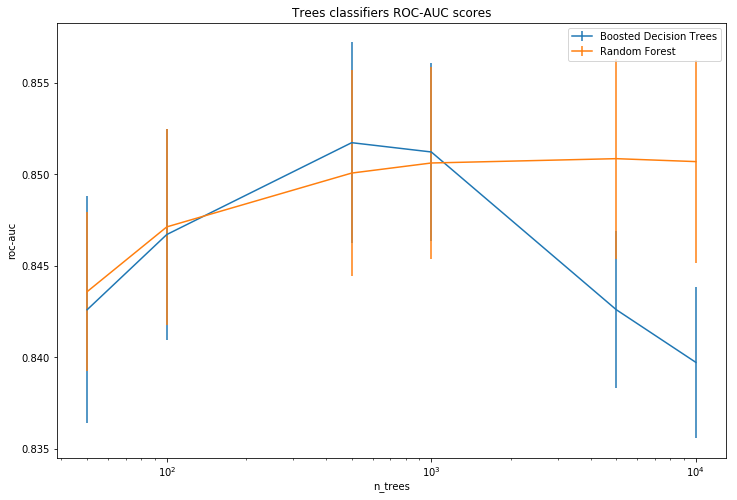

In [92]:
#plot
plt.figure(figsize=(12,8))
plt.errorbar(n_est, boo_means, yerr=np.sqrt(np.array(boo_vars, dtype=float)), label='Boosted Decision Trees')
plt.errorbar(n_est, rand_means, yerr=np.sqrt(np.array(rand_vars, dtype=float)), label='Random Forest')
plt.title('Trees classifiers ROC-AUC scores')
plt.ylabel('roc-auc')
plt.xlabel('n_trees')
plt.xscale('log')
plt.legend()
plt.savefig('trees.pdf')

# 51. TESTING AREA

In [ ]:
feat_data['TestSample']['phi0'].hist()

In [3]:
f = ROOT.TFile.Open('/home/artem145/NEWS/root_files/Valerio/TestSample/dm_tracks.dm.root','read')

Warning in <TClass::Init>: no dictionary for class DMRViewHeader is available
Warning in <TClass::Init>: no dictionary for class DMRAffine2D is available
Warning in <TClass::Init>: no dictionary for class DMRCluster is available
Warning in <TClass::Init>: no dictionary for class DMRGrain is available
Warning in <TClass::Init>: no dictionary for class DMRMicrotrack is available
Warning in <TClass::Init>: no dictionary for class DMRImageCl is available
Warning in <TClass::Init>: no dictionary for class DMRImage is available
Warning in <TClass::Init>: no dictionary for class DMRFrame is available


In [4]:
t = f.Get('Vdmr')

In [79]:
t.GetEntry(0)

480528

In [80]:
t.GetLeaf('cl.ly').GetValue(1027)

0.1619206815958023

In [107]:
copa = pd.read_csv(root_dir+'TestSample/yandex_bfcl_TestSample.txt').drop(['emp'],axis=1)
copa.head(10)

,ViewID,GrainID,pol0,pol1,pol2,pol3,pol4,pol5,pol6
0,0,0,2128,2137,2147,2156,2163,2171,2177
1,0,4,2333,2337,2340,2343,2348,2349,2352
2,0,6,2533,2537,2538,2541,2544,2546,2548
3,0,19,1718,1719,1720,1721,1722,1713,1723
4,0,24,1658,1659,1661,1662,1663,1664,1665
5,0,28,1588,1589,1591,1594,1596,1598,1600
6,0,38,1481,1484,1486,1458,1460,1462,1465
7,0,39,2457,2459,2461,2446,2448,2450,2451
8,0,41,1538,1540,1542,1543,1544,1545,1547
9,0,57,1317,1321,1322,1324,1326,1328,1331


In [128]:
%%time
pols = []
for i in range(7):
    pols.append(get_pol_feat(copa, i, root_dir, 'TestSample', feat_names))
feat_data = stack_pols(pols, feat_names)

CPU times: user 1min 45s, sys: 3.38 s, total: 1min 49s
Wall time: 1min 49s


In [130]:
feat_data.head(5)

,x0,y0,z0,lx0,ly0,phi0,npx0,vol0,x1,y1,...,npx5,vol5,x6,y6,z6,lx6,ly6,phi6,npx6,vol6
0,20.7725,-15.9359,-22.95,0.181091,0.14048,0.267327,39,316,20.7633,-15.9407,...,45,355,20.7716,-15.9525,-22.95,0.187638,0.144514,0.395403,46,418
1,20.2258,22.9718,-23.95,0.737818,0.32068,0.608326,172,10548,20.2259,22.9667,...,37,415,20.5057,23.1455,-23.95,0.544898,0.303975,2.50439,27,268
2,20.0909,22.9088,-23.15,0.427617,0.215545,1.59147,60,1571,20.097,22.8952,...,9,236,20.2524,23.0559,-23.2,0.0688121,0.0688121,0,5,102
3,27.2961,22.7063,-15.2,0.163098,0.146182,0.81736,28,147,27.2934,22.712,...,6,16,27.296,22.6969,-15.25,0.209391,0.152747,3.04847,23,87
4,31.0651,16.1804,-12.95,0.288794,0.192397,2.89978,62,624,31.0564,16.1784,...,55,430,31.0325,16.1644,-13,0.257539,0.183618,3.04189,66,572


In [87]:
t.GetLeaf('cl.ly').GetValue(2533)

0.2155449092388153

In [106]:
t.GetLeaf('cl.ly').GetValue(int(coco))

0.14048033952713013

In [18]:
ROOT.gROOT.ProcessLine("2*sin(2.1*4.0)")

1

(double) 1.7091978


In [6]:
ROOT.gROOT.ProcessLine("struct staff_t { Float_t cl_x; TBranch b_cl_x; }" )

0

In [9]:
toto = ROOT.staff_t()
t.SetBranchAddress('cl.x', ROOT.AddressOf(toto,'cl_x'))

4